# KUKA - Document Rectification
Perspective rectification and background croping

### Reference
https://stackoverflow.com/questions/7263621/how-to-find-corners-on-a-image-using-opencv
https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

#### History
- 23-05-2023
    - select quadrangle with criterion base on paper: Complex document classifiaction adn localization application on Identity document images

In [21]:
import sys
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
#sys.path.insert(0, 'd:/Project/kuka-py/')
from kukalib.cardcrop import *
print(getVersionInfo())

{'version': '0.2.0', 'date': datetime.date(2023, 3, 8)}


In [100]:
import math

line1 = [(0, 0), (15, 15)]
line2 = [(0, 15), (15,  0)]

print(get_angle(line1, line2))

90.0


## Load image

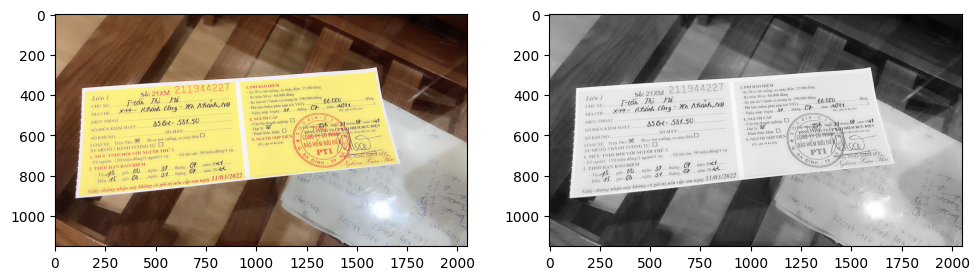

In [131]:
filename=r"D:\Google-drive-huy-work\imagedata\xemay\img35.jpg" #not ok
filename=r"D:\Google-drive-huy-work\imagedata\xemay\img5.jpg" #ok

src=cv2.imread(filename)

gray=cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.show()

## Step 1: try to extract background
### using Morph_Close to remove text

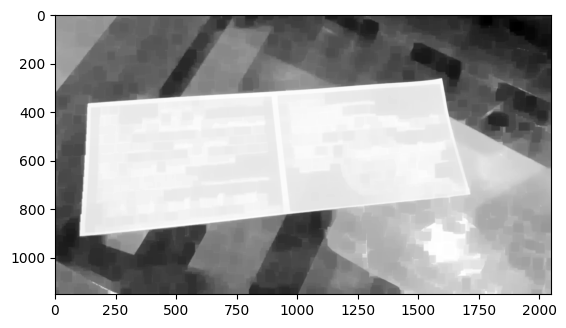

In [132]:
kernel=np.ones((7,7),np.uint8)
dilectImg=cv2.morphologyEx(src,cv2.MORPH_CLOSE,kernel,iterations=5)

gray=cv2.cvtColor(dilectImg,cv2.COLOR_BGR2GRAY)
    
blurImg=cv2.GaussianBlur(gray,(5,5),0)

plt.imshow(blurImg,cmap='gray')
plt.show()

## Step 2: edge and line detect

In [133]:
sobelImg=sobel(blurImg)
ret1,edgeImg = cv2.threshold(sobelImg,40,200, cv2.THRESH_OTSU + cv2.THRESH_TOZERO + cv2.THRESH_BINARY)

#edgeImg=cv2.Canny(blurImg,40,200)
## make egde more dilect
#edgeImg=cv2.morphologyEx(edgeImg,cv2.MORPH_DILATE,(3,3),iterations=2)

lines = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)


Num of line: 164


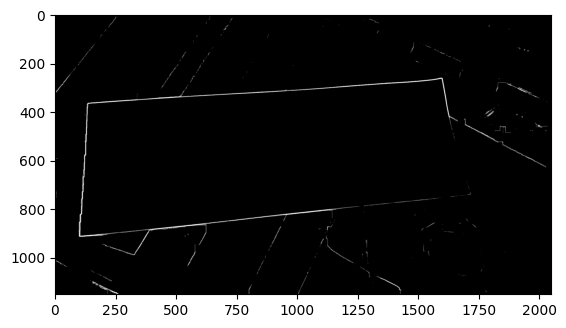

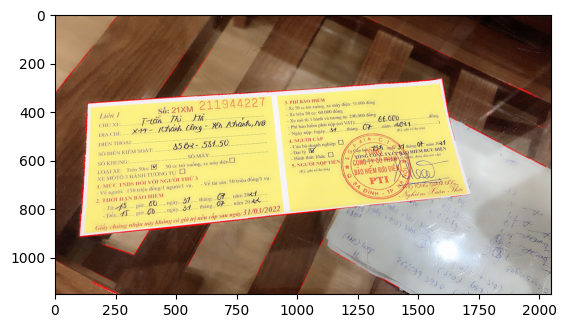

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [134]:
# print debug line
lineImg=src.copy()
print('Num of line:', len(lines))
for line in lines:
    x1=line[0][0]
    y1=line[0][1]
    x2=line[0][2]
    y2=line[0][3]
    cv2.line(lineImg,(x1,y1),(x2,y2),(0,0,255),1)

plt.imshow(edgeImg,cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.show()

print(edgeImg[:100])

## Step 3: trying to find quadrilateral by estimating 4 lines: top/bottom , left/right
    Asumption:
        - card is nearly center of image
        - 4 edges of card nearly present in the image
    

In [135]:
x=0
y=0
w=src.shape[1]
h=src.shape[0]

#assumpt: card is center of image and the skew angle is less than 45 degree
xcenter=w/2
ycenter=h/2

hLine=(x,y+h/2,x+w,y+h/2)
vLine=(x+w/2,y, x+w/2,y+h)

hLine=np.array(hLine).astype(np.int32)
vLine=np.array(vLine).astype(np.int32)

maxTLineLen=0
maxBLineLen=0
maxLLineLen=0
maxRLineLen=0
topline=[]
bottomline=[]
leftline=[]
rightline=[]
topleftPoint=[]
toprightPoint=[]
bottomleftPoint=[]
bottomrightPoint=[]


for line in lines:
    p1=line[0][0:2]
    p2=line[0][2:4]
    angle= getLineAngle(p1,p2)
    angle=abs(angle)

    length=getLineLength(p1,p2)
    if(angle<45): # top/bottom line
        if(p1[1]+p2[1])/2 < ycenter:
            if maxTLineLen<length:
                maxTLineLen=length
                topline=line[0]
        elif (p1[1]+p2[1])/2 > ycenter:
            if maxBLineLen<length:
                maxBLineLen=length
                bottomline=line[0]
    else:
        if (p1[0]+p2[0])/2 < xcenter:
            if maxLLineLen<length:
                maxLLineLen=length
                leftline=line[0]
        elif (p1[0]+p2[0])/2 > xcenter:
            if maxRLineLen<length:
                maxRLineLen=length
                rightline=line[0]

'draw line to debug image'
if len(topline)>0:
    cv2.line(lineImg,topline[0:2],topline[2:4],255,1)
if len(bottomline)>0:
    cv2.line(lineImg,bottomline[0:2],bottomline[2:4],255,1)
if len(leftline)>0:
    cv2.line(lineImg,leftline[0:2],leftline[2:4],255,1)
if len(rightline)>0:
    cv2.line(lineImg,rightline[0:2],rightline[2:4],255,1)

if(len(topline)>0 and len(bottomline)>0 and len(leftline)>0 and len(rightline)>0):
    # tính hệ số (a,b,c) của các đường thẳng
    aL,bL,cL=calcParams(leftline[0:2],leftline[2:4])
    aT,bT,cT=calcParams(topline[0:2],topline[2:4])

    aR,bR,cR=calcParams(rightline[0:2],rightline[2:4])
    aB,bB,cB=calcParams(bottomline[0:2],bottomline[2:4])

    # tìm các giao điểm tl,tr,bl,br
    topleftPoint=findIntersection((aL,bL,cL),(aT,bT,cT))
    toprightPoint=findIntersection((aR,bR,cR),(aT,bT,cT))
    bottomleftPoint=findIntersection((aL,bL,cL),(aB,bB,cB))
    bottomrightPoint=findIntersection((aR,bR,cR),(aB,bB,cB))

    # check if the polygon has four point
    corners=np.array([topleftPoint,toprightPoint,bottomleftPoint,bottomrightPoint])

    corners = order_points(corners)
    
    destination_corners = find_dest(corners)
    
    h, w = src.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    cropedImg = cv2.warpPerspective(src, M, (destination_corners[2][0], destination_corners[2][1]),
                                    flags=cv2.INTER_LINEAR)


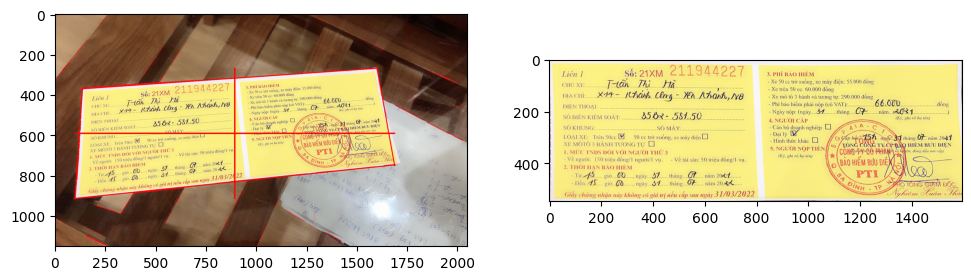

In [136]:
#show debug: middle vertical,hozirontal line of boundingbox
x,y,w,h=cv2.boundingRect(np.float32(corners))
w2=int(w/2)
h2=int(h/2)

cv2.line(lineImg,(x,y+h2),(x+w,y+h2),(0,0,255),5) #horizontal
cv2.line(lineImg,(x+w2,y),(x+w2,y+h),(0,0,255),5) # vertical

cv2.circle(lineImg,topleftPoint,3,(0,0,255),3)
cv2.circle(lineImg,toprightPoint,3,(0,0,255),3)
cv2.circle(lineImg,bottomleftPoint,3,(0,0,255),3)
cv2.circle(lineImg,bottomrightPoint,3,(0,0,255),3)

cv2.line(lineImg,topleftPoint,toprightPoint,(0,0,255),3)
cv2.line(lineImg,toprightPoint,bottomrightPoint,(0,0,255),3)
cv2.line(lineImg,bottomrightPoint,bottomleftPoint,(0,0,255),3)
cv2.line(lineImg,bottomleftPoint,topleftPoint,(0,0,255),3)


figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
plt.show()



In [142]:
def verifyQuadrilateral(topline,bottomline,leftline,rightline):
    """
    Check 4 lines can create a  quadrangle shape that meet with following criterion
    Input: lines in shape (2,2) points
    """
    isQuadrangle=True
    criterion = True
    a_angle = get_angle(topline,leftline)
    b_angle = get_angle(topline,rightline)
    c_angle = get_angle(bottomline,rightline)
    d_angle = get_angle(bottomline,leftline)
    print("A:{:.2f}\tB:{:.2f}\tC:{:.2f}\tD:{:.2f}".format(a_angle,b_angle,c_angle,d_angle))

    #criterion 1
    minParallelAngle=5 
    toplineAngle=getLineAngle(topline[0],topline[1])
    bottomlineAngle=getLineAngle(bottomline[0],bottomline[1])
    leftlineAngle = getLineAngle(leftline[0],leftline[1])
    rightlineAngle =getLineAngle(rightline[0],rightline[1])
    criterion = abs(toplineAngle) - abs(bottomlineAngle) < minParallelAngle and abs(leftlineAngle) - abs(rightlineAngle)<minParallelAngle
    print("Meet criterion 1:",criterion)
    print("\tAngle line of Top {:.2f} - bottom {:.2f}  - left: {:.2f} - right: {:.2f} ".format(toplineAngle,bottomlineAngle,leftlineAngle,rightlineAngle))
    
    #criterion 2
    diffOppositeAngle=10
    criterion = (a_angle-b_angle+c_angle-d_angle)/2 <diffOppositeAngle and (a_angle-d_angle+b_angle-c_angle)/2<diffOppositeAngle
    isQuadrangle = isQuadrangle and criterion
    print("Meet criterion 2:",criterion)
    #criterion 3
    averagePerpendicular =25 
    criterion =  abs((a_angle+b_angle+c_angle+d_angle)/4-90) < averagePerpendicular
    isQuadrangle =isQuadrangle and criterion
    print("Meet criterion 3:",criterion)    

    return isQuadrangle

verifyQuadrilateral(topline.reshape(2,2),bottomline.reshape(2,2),leftline.reshape(2,2),rightline.reshape(2,2))


A:82.05	B:83.78	C:85.78	D:80.05
Meet criterion 1: False
	Angle line of Top -3.98 - bottom -5.98  - left: -86.04 - right: 79.80 
Meet criterion 2: True
Meet criterion 3: True


True

In [138]:
# calculate angle A,B,C,D
print(topline.reshape(2,2))
a_angle = get_angle(topline.reshape(2,2),topline.reshape(2,2))
print (a_angle)

[[ 759  328]
 [1549  273]]
0.0
